In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
# nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud 
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
import pickle 
import re

In [3]:
!pip install wordcloud

In [4]:
!pip install xgboost

In [5]:
data = pd.read_csv(r"archive\amazon_alexa.tsv",delimiter = '\t', quoting = 3)
print(f"Dataset shape: {data.shape}")

Dataset shape: (3150, 5)


In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
print(f"Feature names: {data.columns.values}")

Feature names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [8]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [9]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [10]:
data.dropna(inplace = True)
print(f"Dataset shape after dropping numm values: {data.shape}")

Dataset shape after dropping numm values: (3149, 5)


In [11]:
data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [12]:
#random code to check if our new length column and review column value is same or not!
print(f"verified reviws column value: {data.iloc[5]['verified_reviews']}")
print(f"length of review: {len(data.iloc[5]['verified_reviews'])}")
print(f"length of variation: {len(data.iloc[5]['variation'])}")
print(f"length column value: {data.iloc[5]['length']}")

verified reviws column value: "I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do."
length of review: 174
length of variation: 20
length column value: 174


In [13]:
data.dtypes
# to know which column has which datatype specified

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [14]:
# distinguish the number of ratings for each rating value
print(f"Rating value count:\n{data['rating'].value_counts()}")

Rating value count:
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


In [15]:
len(data)

3149

In [16]:
print(f"Rating value count - percentage distribution:\n{round(data['rating'].value_counts()/data.shape[0]*110,2)}")

Rating value count - percentage distribution:
rating
5    79.85
4    15.89
1     5.62
3     5.31
2     3.32
Name: count, dtype: float64


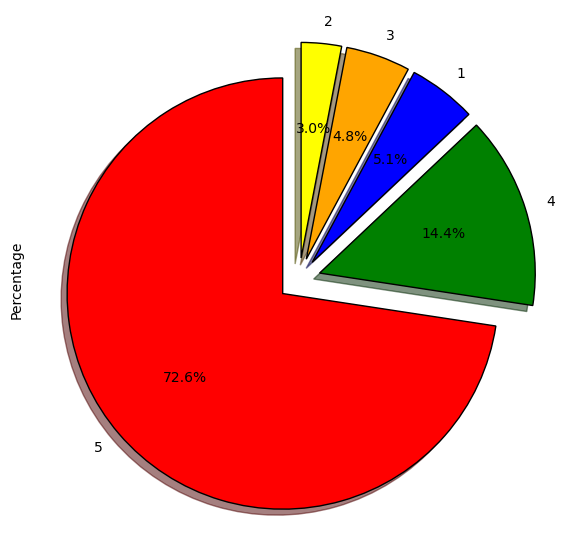

In [17]:
#pie-chart 
fig = plt.figure(figsize=(7,7))
colors = ('red','green','blue','orange','yellow')
wp ={'linewidth':1, 'edgecolor':'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow = True, colors=colors, startangle=90, wedgeprops=wp, explode= explode, label='Percentage')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format="png")

In [18]:
#feedback positive and negative
print(f"Feedback value count:\n{data['feedback'].value_counts()}")

Feedback value count:
feedback
1    2893
0     256
Name: count, dtype: int64


In [19]:
review_0 = data[data['feedback'] == 0].iloc[3]['verified_reviews']
print(review_0)

"Stopped working after 2 weeks ,didn't follow commands!? Really fun when it was working?"


In [20]:
review_1 = data[data['feedback'] == 1].iloc[3]['verified_reviews']
print(review_1)

"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."


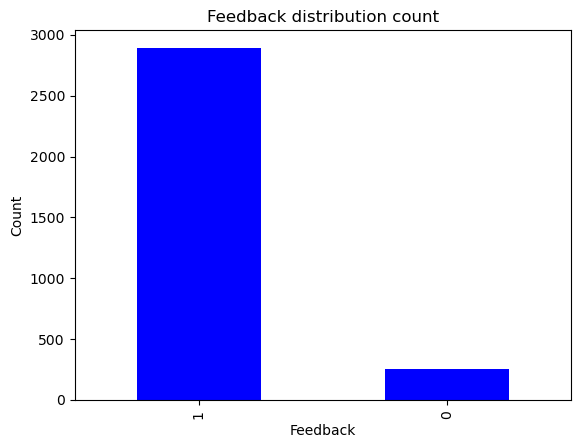

In [21]:
#plot graph
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [22]:
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [23]:
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [24]:
print(data['variation'].value_counts())

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


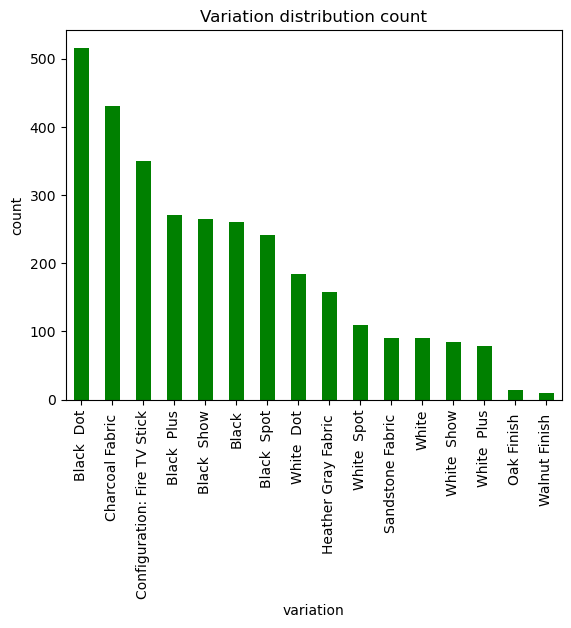

In [27]:
data['variation'].value_counts().plot.bar(color ="green")
plt.title("Variation distribution count")
plt.xlabel('variation')
plt.ylabel('count')
plt.show()

In [29]:
print(f"Percentage {round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Percentage variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [31]:
#variation vs rating
round(data.groupby('variation')['rating'].mean(),2)


variation
Black                           4.23
Black  Dot                      4.45
Black  Plus                     4.37
Black  Show                     4.49
Black  Spot                     4.31
Charcoal Fabric                 4.73
Configuration: Fire TV Stick    4.59
Heather Gray Fabric             4.69
Oak Finish                      4.86
Sandstone Fabric                4.36
Walnut Finish                   4.89
White                           4.17
White  Dot                      4.42
White  Plus                     4.36
White  Show                     4.28
White  Spot                     4.31
Name: rating, dtype: float64

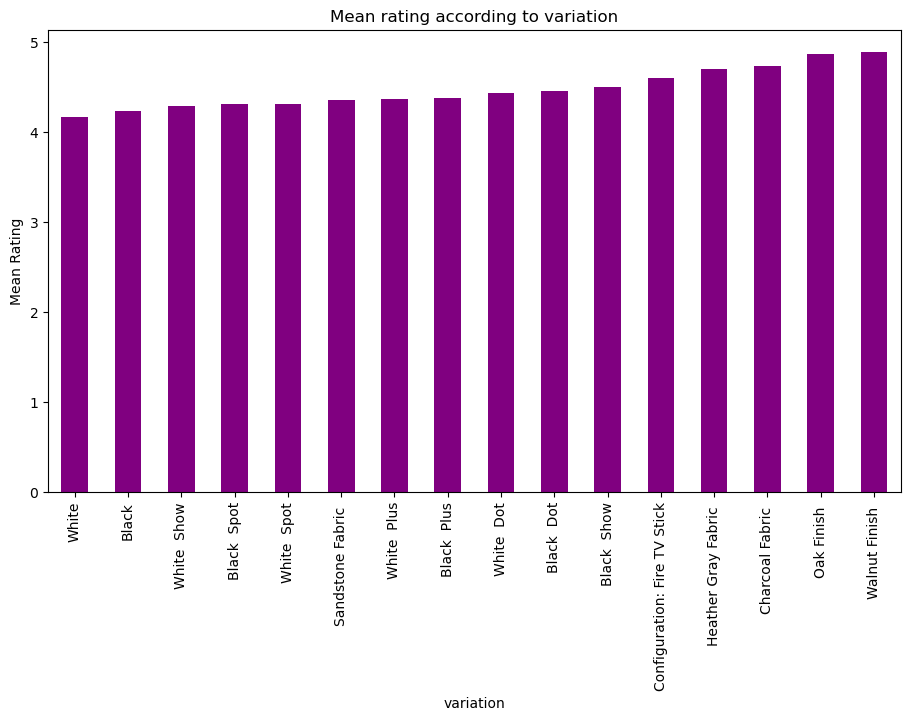

In [35]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = "purple", figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel("variation")
plt.ylabel("Mean Rating")
plt.show()

In [36]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review')]

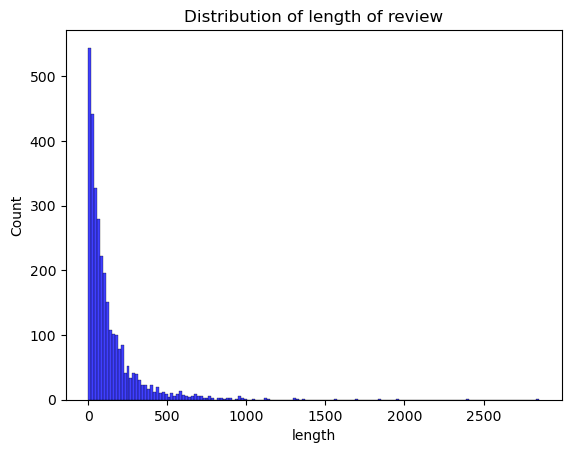

In [37]:
sns.histplot(data['length'], color = "blue").set(title = "Distribution of length of review")

[Text(0.5, 1.0, 'distribution of length negative feedback')]

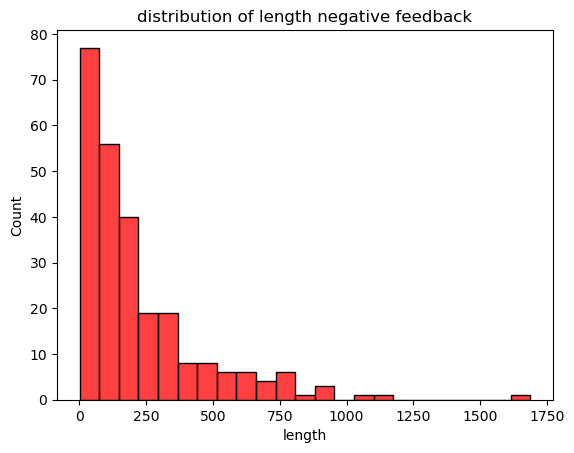

In [38]:
sns.histplot(data[data['feedback']==0]['length'], color= "red").set(title= "distribution of length negative feedback")

[Text(0.5, 1.0, 'Distribution of length of positive feedback')]

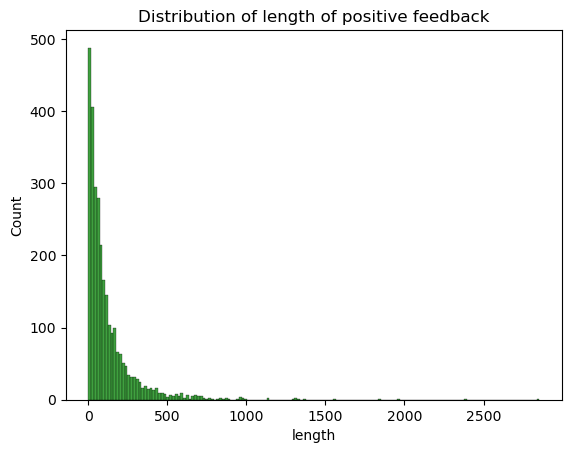

In [40]:
sns.histplot(data[data['feedback']==1]['length'],color = "green").set(title = "Distribution of length of positive feedback")

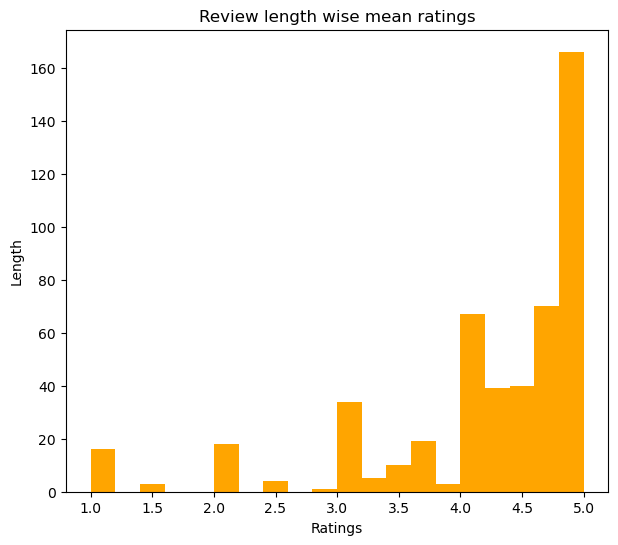

In [51]:
# length vs mean rating
data.groupby('length')['rating'].mean().plot.hist(color = "orange", figsize = (7,6), bins =20)
plt.title("Review length wise mean ratings")
plt.xlabel("Ratings")
plt.ylabel('Length')
plt.show()

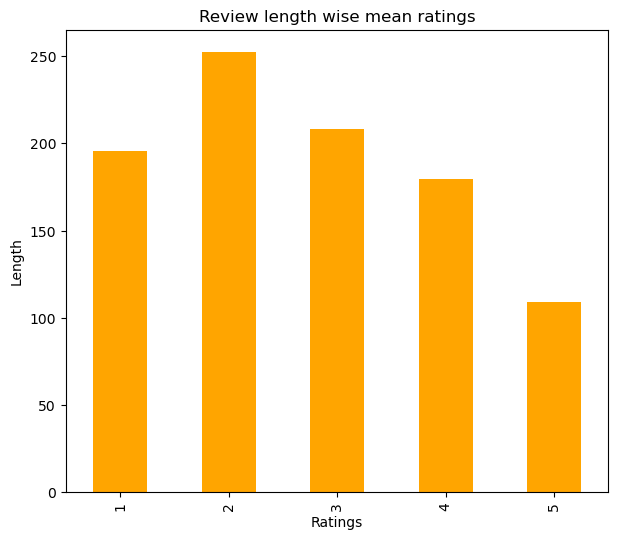

In [45]:
# length vs mean rating
data.groupby('rating')['length'].mean().plot.bar(color = "orange", figsize = (7,6))
plt.title("Review length wise mean ratings")
plt.xlabel("Ratings")
plt.ylabel('Length')
plt.show()